In [12]:
#=============================================================================
# class Cell
# usage: cell = Cell(k,g,K,P)
#        nrs = Neurons(4,10)
#        can = nrs.canvas();
#        cell.place(nrs,(i,j))
#=============================================================================

from carabao.graphics import Neurons

class Cell:
    def __init__(self,k,g,K,P):
        self.config(k,g,K,P)
        self.x = 0
        self.y = 0
        self.u = 0
        
    def config(self,k,g,K,P):
        self.k = k;
        self.g = g;  
        self.K = K;
        self.P = P;
    
    def place(self,neurons,ij):
        self.neurons = neurons
        self.ij = ij

    def plot(self):
        self.neurons.cell(self.ij,self.x,self.y,self.P)
        self.neurons.input(self.ij[1],self.u)



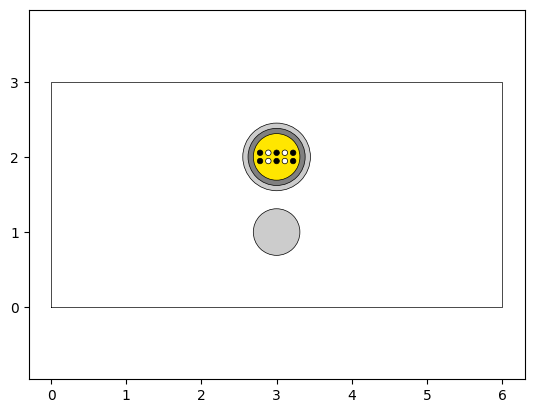

In [28]:
import time
import matplotlib.pyplot as plt

nrs = Neurons(1,5)
can = nrs.canvas()
cell = Cell([],[],[],None)
cell.place(nrs,(0,2))
cell.plot()
plt.show()

# excite cell

time.sleep(2)
cell.u = 1
cell.plot()
plt.show()

# set cell predictive

time.sleep(2)
cell.x = 1
cell.plot()
plt.show()

# set cell active

time.sleep(2)
cell.y = 1
cell.plot()
plt.show()
